# Práctica 3: Tarea de regresión

## Vladimir García Loginova

## Instrucciones

La tercer práctica consiste en predecir el valor de una variable a partir de un conjunto de variables predictoras en un dataset de venta de casas en Italia. La variable a predecir será el precio de una casa.

Se deberá realizar:
La limpieza de los datos.
Un análisis exploratorio de los datos.
Una técnica de reducción de dimensionalidad.
Extracción de características para crear por lo menos 2 atributos nuevos (que sean interesantes).
Aplicar al menos dos técnicas de selección de características.
Entrenar al menos 4 modelos de regresión diferentes (uno tiene que ser regresión lineal),
Reportar el resultado de evaluación con una partición de los datos local.
Reportar el resultado de evaluación con un conjunto de datos de prueba que se les será proporcionado dos días antes.
Escribir una discusión y las conclusiones sobre el trabajo realizado.
La métrica a utilizar será R².

### Importe de paqueterías

In [1]:
# importe de pauqterías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.manifold import TSNE
from umap import UMAP
from datetime import datetime
import time

### Lectura de dataset

In [2]:
file="train_housing_data_italy.csv"
df=pd.read_csv(file)
print(df)
print(df.columns)

           timestamp      location  \
0       1.661114e+09     siculiana   
1       1.661114e+09     strongoli   
2       1.661114e+09        zelbio   
3       1.661114e+09    villamagna   
4       1.661114e+09  vallefiorita   
...              ...           ...   
213404  1.661159e+09          bari   
213405  1.661159e+09          bari   
213406  1.661159e+09          bari   
213407  1.661159e+09          bari   
213408  1.661159e+09          bari   

                                                    title     price  n_rooms  \
0        villa unifamiliare via campo spoto 38, siculiana   46000.0      4.0   
1       quadrilocale contrada tronga 211, tronca, stro...  120000.0      4.0   
2               bilocale buono stato, piano terra, zelbio   55000.0      2.0   
3       casa colonica, da ristrutturare, 319 m², villa...  130000.0      4.0   
4                 appartamento corso italia, vallefiorita   30000.0      NaN   
...                                                   ...      

### Limpieza de datos

Primero se analizarán diversas variables para ver si tienen información útil o pueden eliminarse.

In [3]:
# vemos a que fechas corresponden los datos de timestamp
print(df['timestamp'].apply(datetime.fromtimestamp))
# se observa registros de availability
print(df.availability.unique())
print(df.status.unique())



0        2022-08-21 13:34:39
1        2022-08-21 13:34:40
2        2022-08-21 13:34:40
3        2022-08-21 13:34:40
4        2022-08-21 13:34:41
                 ...        
213404   2022-08-22 01:56:57
213405   2022-08-22 01:56:57
213406   2022-08-22 01:56:57
213407   2022-08-22 01:56:58
213408   2022-08-22 01:56:58
Name: timestamp, Length: 213409, dtype: datetime64[ns]
['not free / other']
['other']


Vemos que las variables timestamp, availability  y status no ofrecen información útil para el dataset por lo que se procede a eliminar las variables.

In [4]:
df2=df.drop(columns=['timestamp', 'availability','status'])

Ahora se eligen las columnas donde si el dato es NaN, es preferible eliminar el registro (fila) para no tener sesgo en nuestro estudio. Variables (columnas) donde se eliminan las filas con NaN: price, year_of_constructiion, n_bathrooms y n_rooms.

In [5]:
print(df2.columns)
#Se quitan registros donde el precio sea nan
print(df2.shape)
df3 = df2.dropna(subset=['price', 'n_rooms','n_bathrooms', 'year_of_construction','mq'])
df3=df3.drop_duplicates()
df3 = df3.drop(df3[df3.price < 100].index)
print(df3.shape)


Index(['location', 'title', 'price', 'n_rooms', 'floor', 'mq', 'n_bathrooms',
       'year_of_construction', 'energy_class', 'heating', 'has_garage',
       'has_terrace', 'has_garden', 'has_balcony', 'has_fireplace',
       'has_alarm', 'has_air_conditioning', 'has_pool', 'has_parking',
       'has_elevator', 'is_furnished', 'latitude', 'longitude'],
      dtype='object')
(213409, 23)
(128552, 23)


Vemos que se elimnaron cerca de 2/5 partes del dataset. Si bien esto es una cantidad alta, esto permitirá tener resultados más consistentes, ya que se tiene un buen número de registros.

### Ánalisis exploratorio

Como primer análisis exploratorio, se busca cual es el precio promedio de las casas usando las siguientes variables:
n_rooms y n_bathrooms.

In [6]:
print(df3.groupby(["n_rooms"])[["price"]].mean())
print(df3.groupby(["n_bathrooms"])[["price"]].mean())
#room=df_5c.loc[df_5c.Location=="Darwin","Rainfall"].max()

                 price
n_rooms               
2.0      113576.582074
3.0      139252.310822
4.0      195252.624549
5.0      198957.931716
                     price
n_bathrooms               
1.0          119329.697706
2.0          210089.338400
3.0          313888.417207


Se observa que si hay una relación entre el precio y el número de cuartos y baños.
Hay una gran dfierencia de precio entre 3 y 4 cuartos, pero no entre 2 y 3 cuartos, ni 4 y 5 cuartos.
La relación del numero de baños con el precio es aparentemente lineal.

Ahora hacemos un scatter plot de precio y año de contrucción.

<Axes: xlabel='year_of_construction', ylabel='price'>

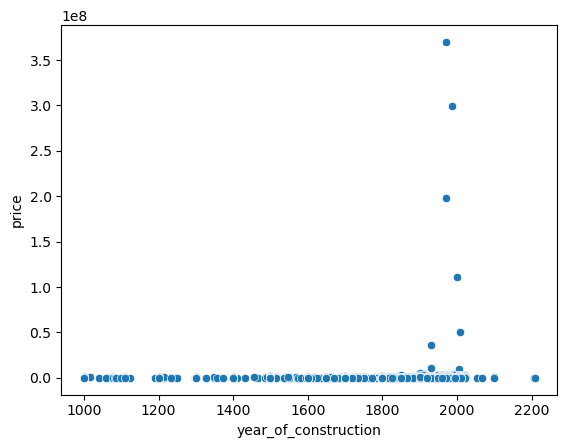

In [7]:
sns.scatterplot( x="year_of_construction", y="price",data=df3)

Aparentemente no se observa una relación entre año de contrucción y precio. Pero también se observan varios outliers del precio, analizamos estos datos viendo sus registros, en este caso, se observan las 100 casas más caras.

In [8]:
#se definen e imprimen los 100 valores mas grandes
max_prices_10=df3.nlargest(100,"price")

print("Las 10 casas con el precio más alto:")
print(max_prices_10.iloc[:,2:8][:10])
print("casa 90 a 100 con el precio más alto:")
print(max_prices_10.iloc[:,2:8][90:])

Las 10 casas con el precio más alto:
              price  n_rooms  floor     mq  n_bathrooms  year_of_construction
86334   370000000.0      2.0    NaN   85.0          1.0                1970.0
209422  299000000.0      4.0    2.0  103.0          2.0                1988.0
51271   198000000.0      4.0    2.0  130.0          2.0                1970.0
122428  111111111.0      4.0    2.0  213.0          1.0                2001.0
75031    50000000.0      4.0    1.0  165.0          1.0                2007.0
69040    36000000.0      3.0    2.0   90.0          2.0                1930.0
165038   11111111.0      3.0    NaN  270.0          1.0                1930.0
20438     9999999.0      3.0    1.0  215.0          1.0                2005.0
157843    5000000.0      5.0    2.0  200.0          3.0                1900.0
157435    4250000.0      4.0    NaN  235.0          3.0                1910.0
casa 90 a 100 con el precio más alto:
            price  n_rooms  floor     mq  n_bathrooms  year_of_cons

Se observan en los resgistros varias anomalías, como precios con puros 1´s o puros 9´s. Algunas de estas casas tienen mas de 3 recamaras y un número grande de metros cuadrados. No obstante, estos datos outliers pueden sesgar mucho el resultado por el excesivo precio de algunas de estas casas, por lo que para este trabajo se quitarán al menos las 100 casas con mayor precio.

<Axes: xlabel='year_of_construction', ylabel='price'>

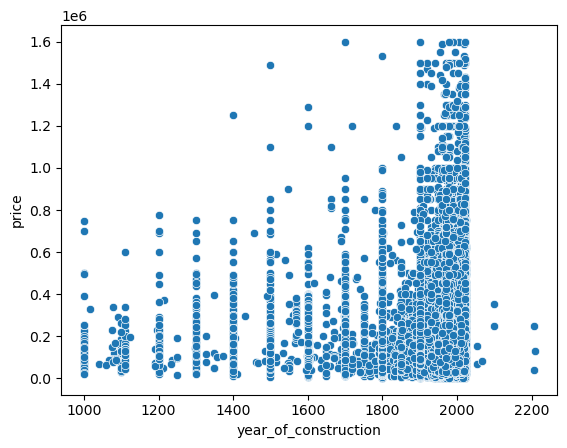

In [9]:
# se quitan los 10 valores mas grandes y se grafica nuevamente
#print(sorted(df4.year_of_construction))
df4=df3.drop(max_prices_10.index.values)
sns.scatterplot( x="year_of_construction", y="price",data=df4)

Se observa que hay lineas raras en los años menores a 1900, por lo que se considera eliminar estos datos.

<Axes: xlabel='year_of_construction', ylabel='price'>

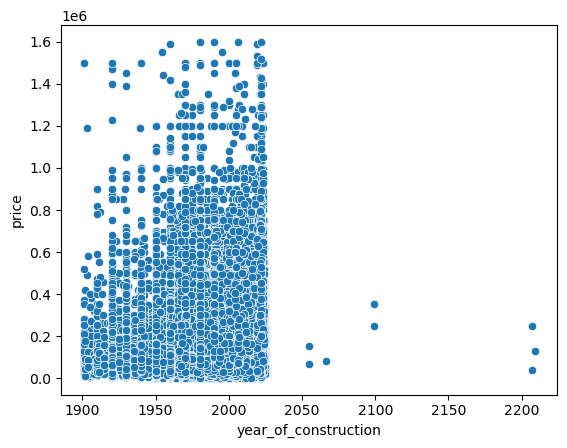

In [10]:
df4_2=df4.loc[df4.year_of_construction>1900,:]
sns.scatterplot( x="year_of_construction", y="price",data=df4_2)

Una ves eliminados los outliers se observa que aparentemente si existe una relación directamente proporcional entre el año de contrucción y el precio de las casas.
Por otra parte, también se observan 9 outliers en el año de contrucción (años que no existen aún), los cuales también se procede a eliminar.

In [11]:
df5=df4_2.drop(df4_2.nlargest(9,"year_of_construction").index.values)

Volvemos a obtener el promedio del precio basado en el numero de cuartos y baños

In [12]:
print(df5.groupby(["n_rooms"])[["price"]].mean())
print(df5.groupby(["n_bathrooms"])[["price"]].mean())

                 price
n_rooms               
2.0       97825.384215
3.0      138559.965004
4.0      179308.007883
5.0      198785.657690
                     price
n_bathrooms               
1.0          112753.419287
2.0          198980.937801
3.0          302396.390520


Vemos que ahora la relación del precio con el número de cuartos es aparentemente lineal, a diferencia de cuando no habíamos quitado los outliers. Respecto a los baños la relación se mantiene.

Finalment, se hace un pairplot de los datos, para ver que variables estan posiblemente relacionadas al precio de las casas.

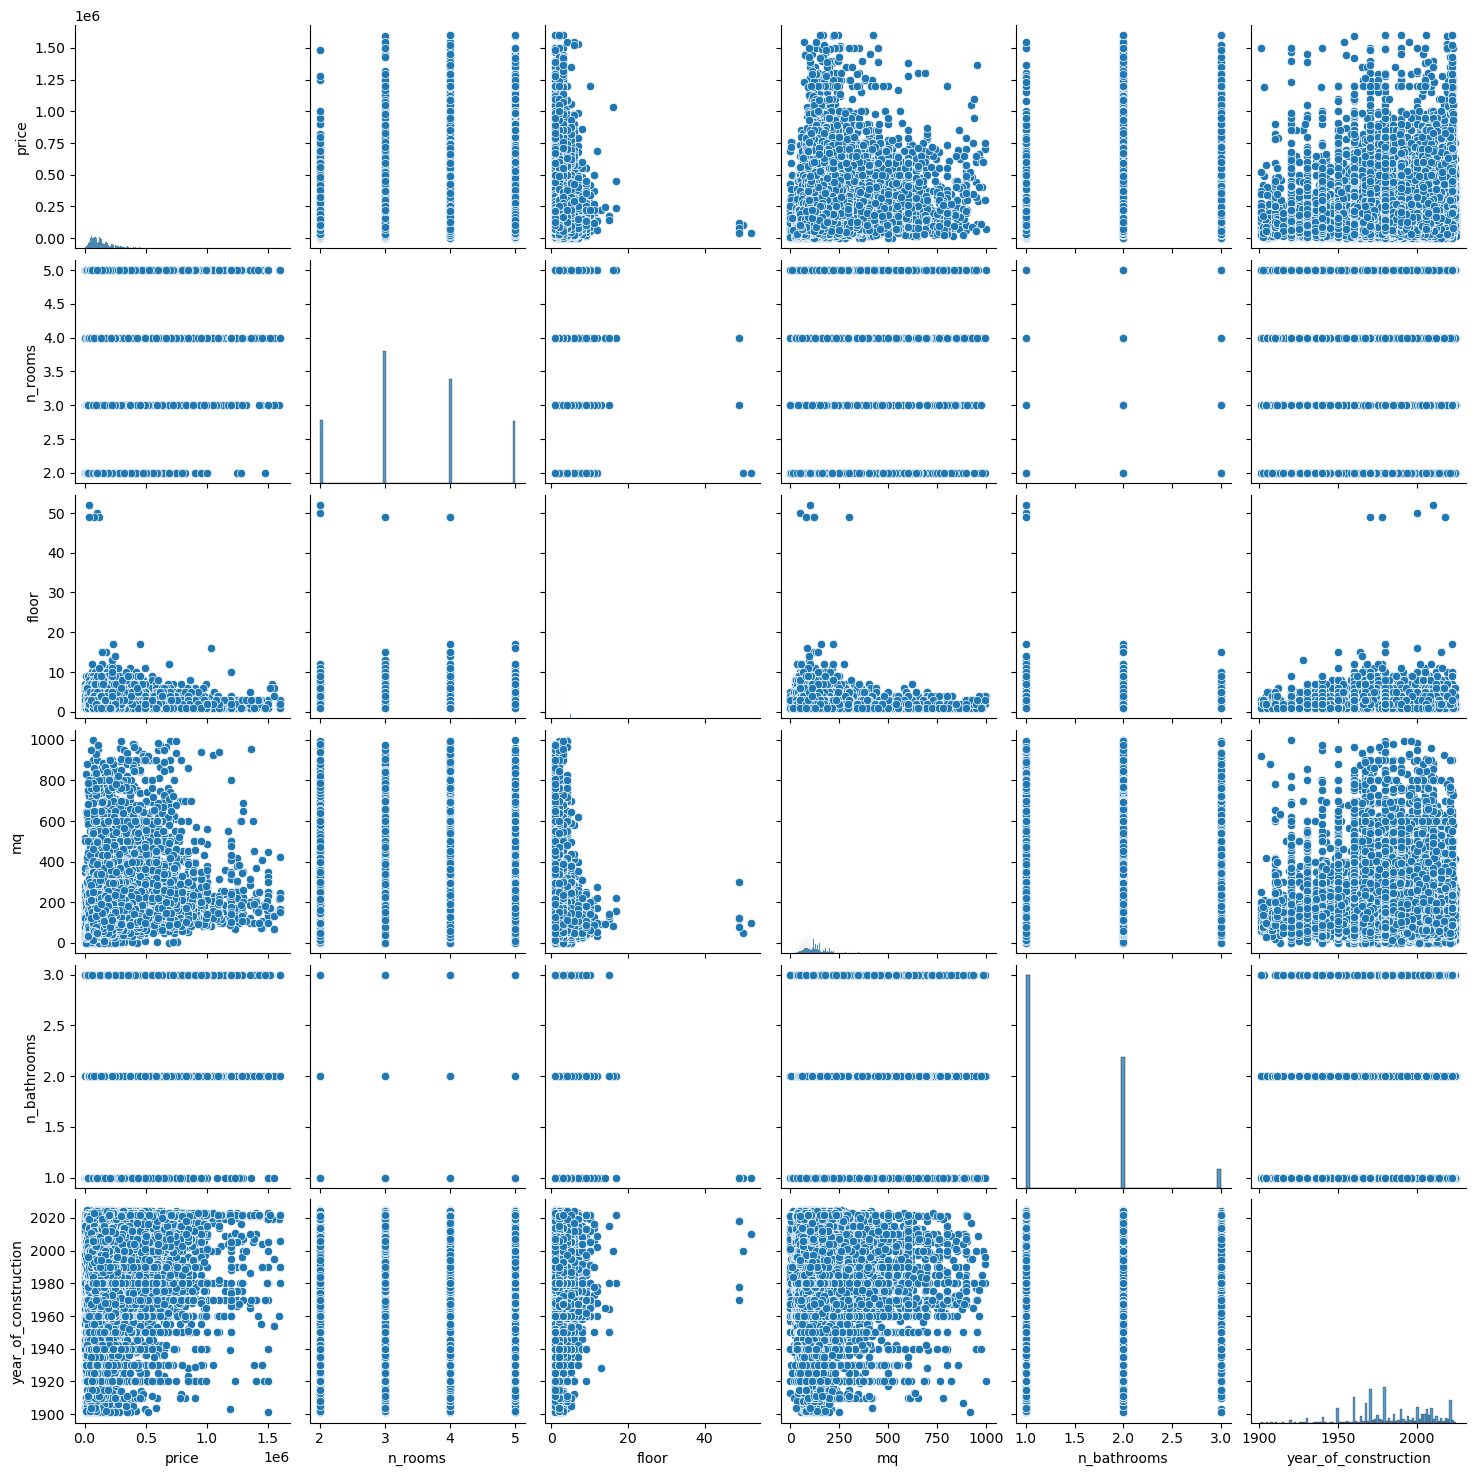

In [13]:
# escogemos algunas variables para hacer el pairplot
df6=df5[['price', 'n_rooms','floor', 'mq', 'n_bathrooms', 'year_of_construction']]
sns.pairplot(df6)

Se observan ligeramente ciertas tendencias. Pero ninguna tan evidente relacionada al precio de las casas.
El precio decrece conforme al número de piso. Y aumenta conforme al año de construcción.
El número de piso aumenta conforme al año de construcción y decrece respecto al número de metros cuadrados.
El número de metros cuadrados aumenta proporcionalmente al año de construcción.

### Extracción de características

Una forma de extraer características es categorizando la variable de price en cuartiles.  A continuación se hace la categorización y se crea la variable "price_cuartil", que contiene las 4 categorías de precios correspondientes del cuartil 1 al 4 de los datos.

In [14]:
#divido prices por quartil
prices=df6.price.values

#generamos matriz de cuartiles
cuartil_matrix = [prices < np.nanpercentile(prices,25),\
             (prices >= np.nanpercentile(prices,25)) & (prices < np.nanpercentile(prices,50)),\
             (prices >= np.nanpercentile(prices,50)) & (prices < np.nanpercentile(prices,75)),\
             prices >= np.nanpercentile(prices,75)]

cuartil_num = [1, 2, 3, 4]

df5=df5.assign(price_cuartil=np.select(cuartil_matrix, cuartil_num))

Graficamos el pairplot, pero ahora con la clasificación de precio por cuartil.

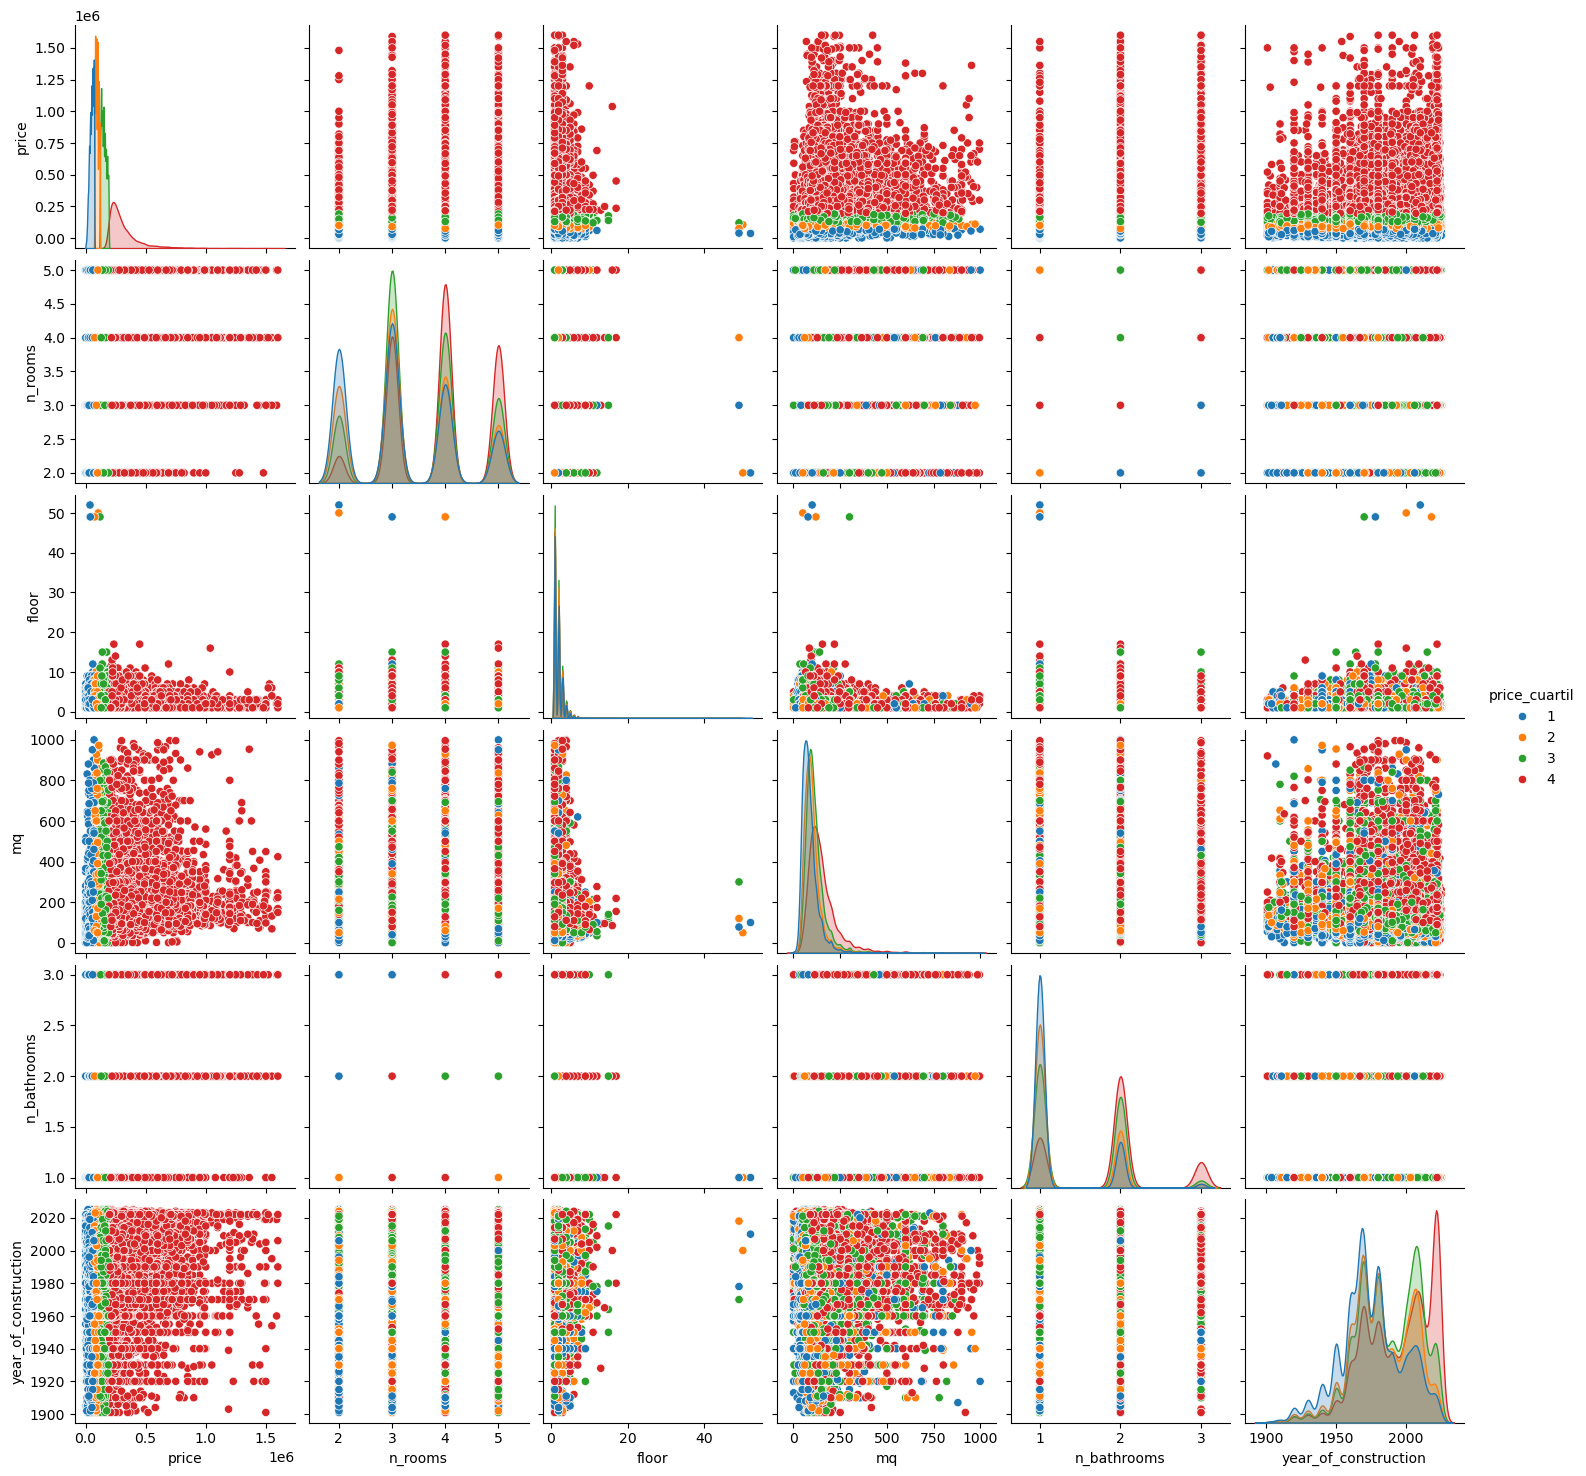

In [15]:
df6=df6.assign(price_cuartil=df5.price_cuartil)
sns.pairplot(df6, hue='price_cuartil',palette = "tab10")

De esta gráfica podemos ver que la variable mq (metros cuadrados) es un buen discriminante entre cuartiles, se puede observar como el 4to cuartil se separa un poco. Muy ligeramente lo mismo ocurre para el año de construcción.

Otra forma de extraer características es combinar 2 columnas, en este caso podemos combinar 2 columnas de tipo "booleano". Para ello vemos cuales de este tipo tienen mas datos, esto se realiza sumando el número de 1´s en cada columna.

In [16]:
bool_columns=['has_garage',
       'has_terrace', 'has_garden', 'has_balcony', 'has_fireplace',
       'has_alarm', 'has_air_conditioning', 'has_pool', 'has_parking',
       'has_elevator', 'is_furnished']
for i in bool_columns:
    print(i,":",df5[i].sum())

has_garage : 24646
has_terrace : 14570
has_garden : 19113
has_balcony : 15107
has_fireplace : 6303
has_alarm : 1322
has_air_conditioning : 36396
has_pool : 1820
has_parking : 2049
has_elevator : 10099
is_furnished : 8671


Vemos que 'has_air_conditioning' y 'has_garage' son las que tienen más datos, por lo que procedemos a combinarlas y crear un nuevo vector, resultado de hacer la operación booleana "and". Es decir, solo será 1 el valor de los registros si ambas variables tienen 1, de lo contrario será 0.

In [17]:
# hacemos operación and entre d
hac_and_hg=(df5['has_air_conditioning'].values & df5['has_garage'].values)
df5=df5.assign(hac_and_hg=hac_and_hg)
# vemos el numero de registros donde ambas son verdadero
print("numero de inmuebles con aire acondicionado y garage:", hac_and_hg.sum())

numero de inmuebles con aire acondicionado y garage: 12421


Ya que combinamos columnas vemos el resultado obteneniendo la media y mediana de price respecto a aire_acond_y_garage (hac_and_hg), para ver si hay una relación entre estas variables.

In [18]:
print(df5.groupby(["hac_and_hg"])[["price"]].mean())
print(df5.groupby(["hac_and_hg"])[["price"]].median())


                    price
hac_and_hg               
0           150459.303134
1           179103.687143
               price
hac_and_hg          
0           119000.0
1           149000.0


Observamos que el precio si aumenta si el inmueble tiene tanto aire acondicionado y garage.

Si bien cambiar registros NaN por 0 no necesariamente es extrarer características (tal ves se puede ver como aumento de datos). Para la variable floor se tienen muchos datos NaN, 41040 para ser específicos, los cuales son bastantes. Podemos convertir estos datos a 0, con tal de no perder mucha información de las otras variables que probablemente tienen información valiosa. Por lo tanto se crea una nueva variable "floor_new" convirtiendo los registros NaN en 0.

In [19]:
print("Número de NaN´s en floor: ",df5.floor.isna().sum())
df5=df5.assign(floor_new=df5.floor.fillna(0))

Número de NaN´s en floor:  37110


## Reducción de dimensionalidad

Para hacer la RD, primero obtenemos un dataframe sin NaN y sin variables categoricas con strings, también quitamos variables de coordenadas.

In [20]:
# quitamos columnas no deseadas
# tambien quitamos la variable floor, porque floor_new tiene valores 0 en nan que pueden ser valiosos
df7=df5.drop(columns=['location', 'title','energy_class','heating','latitude', 'longitude','floor'])

print(df7.shape)
# quitamos nan
df7=df7.dropna()
print(df7.shape)
df7.head()

(117259, 19)
(117259, 19)


,price,n_rooms,mq,n_bathrooms,year_of_construction,has_garage,has_terrace,has_garden,has_balcony,has_fireplace,has_alarm,has_air_conditioning,has_pool,has_parking,has_elevator,is_furnished,price_cuartil,hac_and_hg,floor_new
10,90000.0,5.0,124.0,2.0,2002.0,0,0,0,0,0,0,0,0,0,0,1,2,0,2.0
13,59000.0,4.0,127.0,1.0,2001.0,0,0,0,0,1,0,1,0,0,1,0,1,0,3.0
15,65000.0,2.0,45.0,1.0,1950.0,0,0,0,0,0,0,0,0,0,0,0,1,0,3.0
18,185000.0,4.0,240.0,3.0,1980.0,0,1,0,0,0,0,1,0,0,0,0,3,0,3.0
19,90000.0,5.0,90.0,2.0,1980.0,1,0,0,1,0,0,0,0,0,0,0,2,0,1.0


Vemos que no había más NaN (ya se había hecho limpieza de datos). Ahora procedemos a hacer el dataframe con la variable de "prices_cuartil". Y preparamos X y y para la RD.

In [21]:
#quitamos la columna de fechas
# Obtenemos x para la reducción de dimensionalidad
X = df7.loc[:,~(df7.columns.isin(['price','price_cuartil']))].values
y = df7.price_cuartil.values

Se utiliza LDA para ver si puede clasificar el precio conforme a las 17 variables que lo intentan explicar.

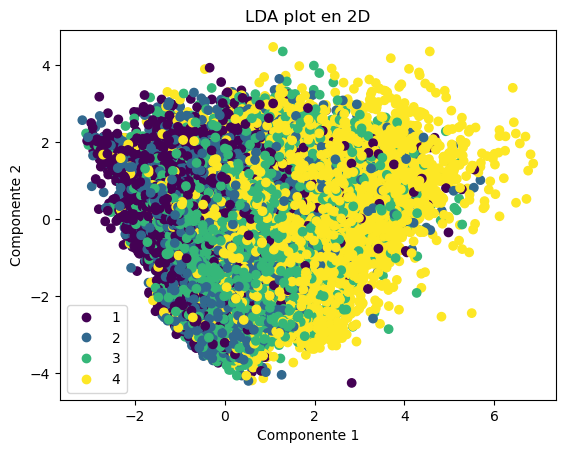

In [22]:
X_LDA = LDA(n_components=2).fit_transform(X,y)

scatter = plt.scatter(X_LDA[:,0], X_LDA[:,1], c=y)
plt.title('LDA plot en 2D')
plt.xlabel('Componente 1')
plt.ylabel('Componente 2')
plt.legend(*scatter.legend_elements())
plt.show()

Vemos una ligera distinción entre los cuartiles de precio.
Probamos con T-SNE también y vemos resultados.

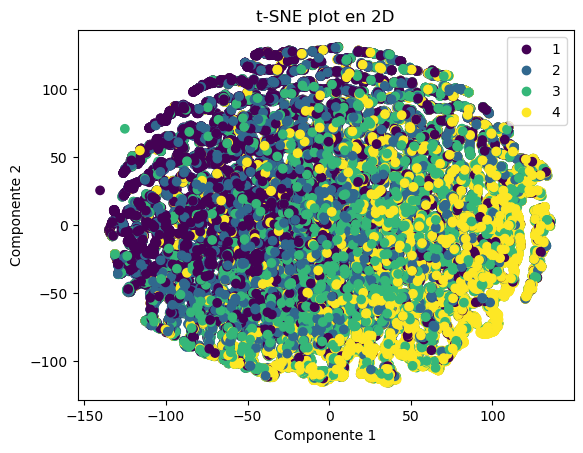

In [23]:
X_TSNE = TSNE(n_components=2).fit_transform(X)

scatter = plt.scatter(X_TSNE[:,0], X_TSNE[:,1], c=y)
plt.title('t-SNE plot en 2D')
plt.xlabel('Componente 1')
plt.ylabel('Componente 2')
plt.legend(*scatter.legend_elements())
plt.show()

Con T-SNE la clasifiación tampoco es tan clara, pero se puede observar una ligera categorización de izquierda a derecha proporcional a los cuartiles de precio.

## Selección de características

### Coeficiente de correlación

<Axes: >

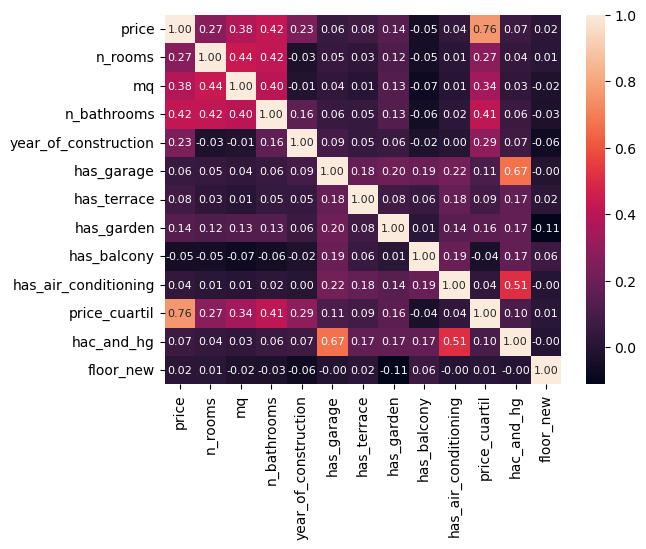

In [24]:
#usamos una matriz más pequeña
df8=df7.drop(columns=['has_alarm', 'has_pool', 'has_parking','has_elevator','has_fireplace','is_furnished'])
corr_mat = df8.corr()
sns.heatmap(corr_mat, annot = True,annot_kws={"size": 8},fmt='.2f')

Del heat map podemos ver  que las variables mas correlacionadas al precio son el número de baños, los metros cuadrados, el número de cuartos y muy ligeramente si tiene jardin. Todas las demás variables tienen un coeficiente menor a  0.1, lo cuál nos habla de poca correlación. 
Otro aspecto importante que se observa es que la variables precio_cuartil presentan correlaciones mas altas en casi todos los casos (excepto con mq), esto nos dice que categorizar los precios por cuartil ayuda a encontrar mejores correlaciones.

A continuación imprimimos las variables correlacionadas con precio en orden descendente.

In [25]:

corr_price=corr_mat['price'].drop('price').drop('price_cuartil')
sorted_corr = corr_price.abs().sort_values(ascending=False)
print(f"Correlaciones absolutas con la variable precio:\n{sorted_corr}")
# Se define umbral para la correción (mantiene variables con |correlación| > 0.2)
threshold = 0.2
selected_features_corr = sorted_corr[sorted_corr > threshold].index.tolist()
print(f"Variables con mayor correlación: {selected_features_corr}")


Correlaciones absolutas con la variable precio:
n_bathrooms             0.421143
mq                      0.375479
n_rooms                 0.266924
year_of_construction    0.234486
has_garden              0.136116
has_terrace             0.077065
hac_and_hg              0.069717
has_garage              0.057319
has_balcony             0.048071
has_air_conditioning    0.036575
floor_new               0.016770
Name: price, dtype: float64
Variables con mayor correlación: ['n_bathrooms', 'mq', 'n_rooms', 'year_of_construction']


### Mutual information

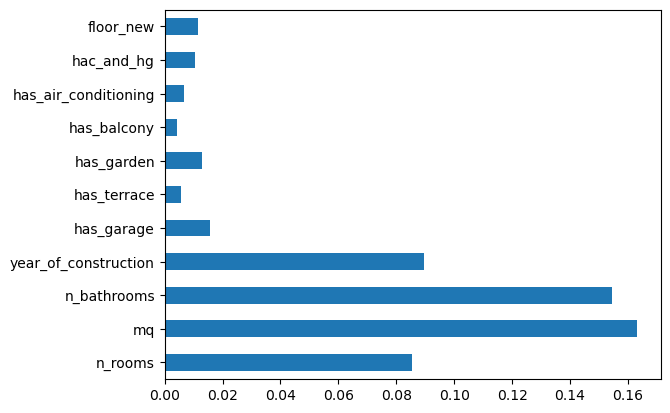

In [26]:
from sklearn.feature_selection import mutual_info_classif

# se quitan columna precio_cuartil
df9=df8.drop(columns=["price_cuartil"])

#Se definen X y y
X = df9.iloc[:, 1:]
y = df9.iloc[:, 0]

### Aplicando método de selección de variables
X_new = mutual_info_classif(X, y)

# se grafica selección de variables
feat_imp = pd.Series(X_new, X.columns)
feat_imp.plot(kind='barh')
plt.show()


De mutual information podemos ver que las variables más relacionadas son (en orden descendente): mq, n_bathrooms, year_of_construction y n_rooms.

Tomando las variables obtenidas de las dos pruebas,  podemos ver que las  variables más relacionadas a la variable de precio son: n_bathrooms, mq, n_rooms, y year_of_construction.

## Modelos de regresión

Importamos paqueterías para las multiples regresiones que se harán

In [27]:
# Importing libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_diabetes

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

En eset caso se utilizan 11 variables para hacer las regresiones. El target consiste de la variable precio.

In [28]:
data=df8.drop(columns=["price_cuartil"])
target=df8.price

Se preparan las variables X y y, y se hace la division de dataset en train y test.

In [29]:
# Splitting data into training and testing sets
X = data.drop('price', axis=1)
y = target
#print(X, y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.head())
print(y_train.head())

        n_rooms     mq  n_bathrooms  year_of_construction  has_garage  \
148177      3.0   85.0          1.0                1971.0           0   
102186      2.0   62.0          1.0                2007.0           0   
207612      4.0  107.0          2.0                1930.0           1   
104126      3.0   70.0          1.0                1930.0           1   
88312       5.0  107.0          2.0                2017.0           0   

        has_terrace  has_garden  has_balcony  has_air_conditioning  \
148177            0           0            0                     0   
102186            0           0            0                     0   
207612            0           1            0                     0   
104126            0           0            0                     0   
88312             0           0            0                     0   

        hac_and_hg  floor_new  
148177           0        2.0  
102186           0        0.0  
207612           0        2.0  
104126      

Función para hacer las regresiones, tal como visto en clase.

In [30]:
# Function to evaluate models and plot predictions
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    model.fit(X_train, y_train)
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    print(f'Model: {model_name}')
    print(f'Train R^2: {r2_score(y_train, y_pred_train):.4f}')
    print(f'Test R^2: {r2_score(y_test, y_pred_test):.4f}')
    print(f'Test RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_test)):.4f}')
    print('-'*40)
    
    # Plot the predictions vs real values
    plt.figure(figsize=(4, 4))
    plt.scatter(y_test, y_pred_test, label='Predictions', color='blue')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(f'Actual vs Predicted - {model_name}')
    plt.legend()
    plt.show()

Modelos de regresión, tal como visto en clase.
En esta celda es donde se manda a llamar la función para evaluar los datasets de train y test.

Model: Linear Regression
Train R^2: 0.2721
Test R^2: 0.2812
Test RMSE: 105467.5106
----------------------------------------


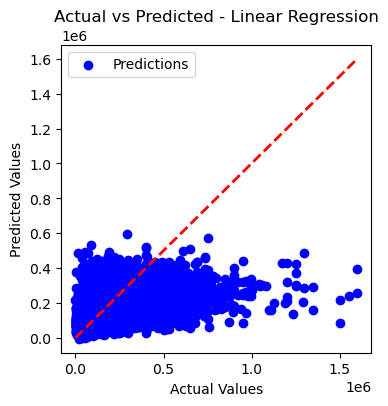

Model: Ridge Regression
Train R^2: 0.2721
Test R^2: 0.2812
Test RMSE: 105467.4995
----------------------------------------


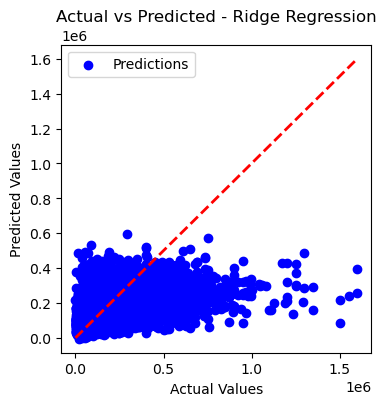

Model: Lasso Regression
Train R^2: 0.2721
Test R^2: 0.2812
Test RMSE: 105467.5055
----------------------------------------


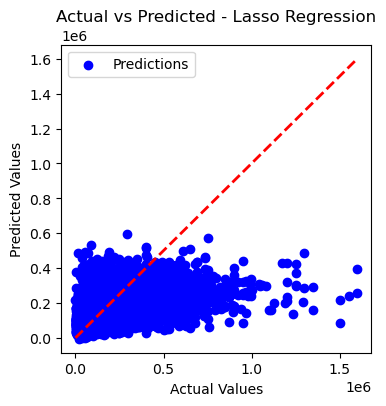

Model: Random Forest Regression
Train R^2: 0.8258
Test R^2: 0.2050
Test RMSE: 110918.8515
----------------------------------------


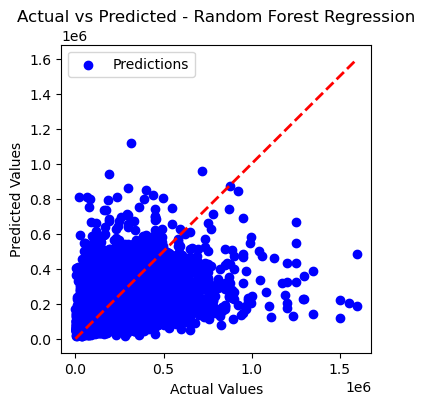

In [31]:
# 1. Linear Regression
linear_reg = LinearRegression()
evaluate_model(linear_reg, X_train, X_test, y_train, y_test, 'Linear Regression')

# 2. Ridge Regression
ridge_reg = Ridge(alpha=1.0)
evaluate_model(ridge_reg, X_train, X_test, y_train, y_test, 'Ridge Regression')

# 3. Lasso Regression
lasso_reg = Lasso(alpha=0.1)
evaluate_model(lasso_reg, X_train, X_test, y_train, y_test, 'Lasso Regression')

# 4. Random Forest Regression
rf_reg = RandomForestRegressor(n_estimators=100, random_state=42)
evaluate_model(rf_reg, X_train, X_test, y_train, y_test, 'Random Forest Regression')

En las primeras tres regresiones (lineal, Ridge y Lasso) se alcanza un valor de R² ~0.27 para el train dataset, mientrás que para el test dataset de ~0.28. El caso de Random Forest es especial, ya que para el train alcanza una R² de ~0.76, pero para el test solamente de ~0.19. Estos resultados nos dicen que no se pudo ajustar adecuadamente un modelo de regresión a los datos, y por lo tanto no es posible predecir el precio de las casas de esta forma.

## Regresión con otro dataset de test

Creamos nuevamente nuestro dataset de entrenamiento para que tenga las mismas columna que el dataset de test. También creamos nuevamente nuestra X y y de entrenamiento.

In [32]:
# Splitting data into training and testing sets
data=df8.drop(columns=['price_cuartil', 'hac_and_hg', 'floor_new'])
X = data.drop('price', axis=1)
y = df8.price

print(X.shape)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train=X
y_train=y

print(X_train.head())
print(y_train.head())

(117259, 9)
    n_rooms     mq  n_bathrooms  year_of_construction  has_garage  \
10      5.0  124.0          2.0                2002.0           0   
13      4.0  127.0          1.0                2001.0           0   
15      2.0   45.0          1.0                1950.0           0   
18      4.0  240.0          3.0                1980.0           0   
19      5.0   90.0          2.0                1980.0           1   

    has_terrace  has_garden  has_balcony  has_air_conditioning  
10            0           0            0                     0  
13            0           0            0                     1  
15            0           0            0                     0  
18            1           0            0                     1  
19            0           0            1                     0  
10     90000.0
13     59000.0
15     65000.0
18    185000.0
19     90000.0
Name: price, dtype: float64


Se crea el test dataset con los datos nuevos que se nos proporcionaron.

In [33]:
file="test_housing_data_italy.csv"
df_test=pd.read_csv(file)

test_data=df_test[data.columns.values].dropna()
X_test2=test_data.drop('price', axis=1)
y_test2=test_data.price
print(X_test2.shape, y_test2.shape)

(6345, 9) (6345,)


Se implementan los modelo de regresón con el dataset de entrenamiento y el test. En este caso no se usó Random Forest porque exigía que el número de datos del training y test datastes fueran iguales.

Model: Linear Regression
Train R^2: 0.2714
Test R^2: -0.0296
Test RMSE: 133583.6478
----------------------------------------


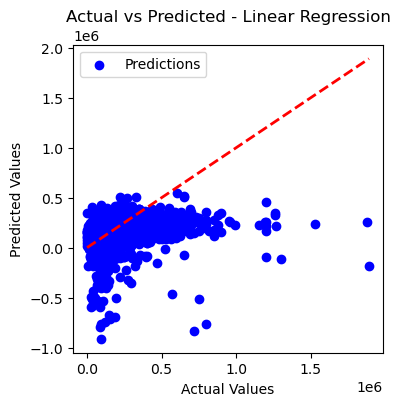

Model: Ridge Regression
Train R^2: 0.2714
Test R^2: -0.0296
Test RMSE: 133583.9475
----------------------------------------


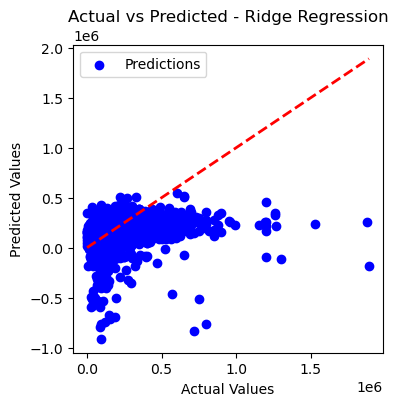

Model: Lasso Regression
Train R^2: 0.2714
Test R^2: -0.0296
Test RMSE: 133583.6903
----------------------------------------


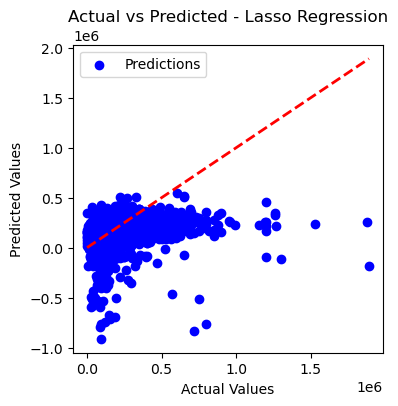

In [34]:
# 1. Linear Regression
linear_reg = LinearRegression()
evaluate_model(linear_reg, X_train, X_test2, y_train, y_test2, 'Linear Regression')

# 2. Ridge Regression
ridge_reg = Ridge(alpha=1.0)
evaluate_model(ridge_reg, X_train, X_test2, y_train, y_test2, 'Ridge Regression')

# 3. Lasso Regression
lasso_reg = Lasso(alpha=0.1)
evaluate_model(lasso_reg, X_train, X_test2, y_train, y_test2, 'Lasso Regression')

# 4. Random Forest Regression
#rf_reg = RandomForestRegressor(n_estimators=100, random_state=42)
#evaluate_model2(rf_reg, X_train, X_test2, y_train, y_test, 'Random Forest Regression')

Se observa que el modelo no ajusta a los datos, con R² inclusive negativas. Esto significa que no fue posible ajustar el test dataset con los coeficientes obtenidos con el dataset de entrenamiento. Es decir, no fue posible predecir el precio de las casas.

## Discusión y conclusiones

El objetivo de esta práctica era predecir una variable a partir de un conjunto de variables predictoras. En este caso la variable objetivo era el precio de las casas en Italia, y las variables predictoras un conjunto de hasta 25 variables. 
Despúes de realizar los procedimientos adecuados, como limpieza de datos, y extracción y selección de características, se implementaron diversos modelos de regresion para intentar predecir el precio de las casas. 
Se ocuparon dos datasets para realizar el test de los modelo. En el primer caso, tanto el test como el entrenamientos se realizaron con un subconjunto del dataset original (preprocesado), el resultado de los ajustes fue muy bajo con una R² de no más de ~0.28. En el segundo caso, se implementaron los modelos utilizando como training el dataset original (preprocesado) y como testing el dataset proporcionado para este fin, el resultado de estas pruebas fue desfavorable, ya que se obtuvierom R² negativas, demostrando que no fue posible encontrar coeficientes que permitieran predecir de forma lineal el valor de las casas en Italia.

A continuación se mencionan las posibles causas de porque no fue posible predecir la variable de precio:

1. A pesar de la limpieza de datos hecha, existe la probabilidad de que el dataset tenga muchos datos erroneos no evidentes.
2. No se hizo el suficiente "Data Engineering" (como extracción de características) para mejorar el rendimiento del modelo.
3. No se escogieron las variables adecuadas para hacer las regresiones.
4. El comportamiento del precio de las casas no es lineal respecto a otras variables.

A pesar de no obtener los resultados esperados, a lo largo de este trabajo se encontraron elementos interesantes. En el análisis exploratorio se observó que el precio promedio de las casas si aumentaba respecto algunas variables. En la limpieza de datos se encontraron multiples errores, que una vez solucionados permitieron mejorar el rendimiento de los modelos. En la extracción de características también fue posible ver como aumentaba el precio de las casas respecto a nuevas variables. De igual manera, con las técnicas de reducción de dimensionalidad se pudo observar una ligera clasificación del precio de las casas. 

Por último, se logro obtener un valor mínimo de R² cuando se usó el subconjunto del dataset original, que si bien en la práctica no es muy útil, sirvió como punto de referencia para mejorar el preprocesamiento de los datos, y para intuir que tal ves el precio de las casas en los datasets utilizados no se puede predecir con un modelo lineal.
